In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Mounted at /content/drive


In [ ]:
from tqdm import tqdm
import os
import librosa
import pickle

# Define a function to extract Mel-spectrograms from audio files
def extract_mel_spectrogram(audio_path, n_mels=128, n_fft=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, duration=5)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Function to process all files in a directory recursively
def process_directory(directory, status):
    data = []
    valid_prefixes = ("VA2", "VE2", "VI2", "VO2", "VU2")
    for root, _, files in os.walk(directory):
        for i, filename in enumerate(tqdm(files, desc=f'Processing {directory}')):
            if filename.endswith('.wav') and filename.startswith(valid_prefixes):
                filepath = os.path.join(root, filename)
                patient_id = os.path.dirname(filepath)  # Get the parent directory as the patient ID
                mel_spectrogram = extract_mel_spectrogram(filepath)
                if mel_spectrogram is not None:
                    data.append((mel_spectrogram, status, patient_id))
    return data

# Function to extract the data source from the directory path
def get_data_source(directory_path):
    parts = directory_path.split('/')
    try:
        mydrive_index = parts.index('MyDrive')
        return parts[mydrive_index + 1]
    except ValueError:
        return 'unknown_source'

# Paths to the directories
pd_directory = '/content/drive/MyDrive/Italian Parkinson\'s Voice and speech/28 People with Parkinson\'s disease'
hc_directory_elderly = '/content/drive/MyDrive/Italian Parkinson\'s Voice and speech/22 Elderly Healthy Control'
hc_directory_young = '/content/drive/MyDrive/Italian Parkinson\'s Voice and speech/15 Young Healthy Control'

# Extract data source from the directory path
data_source = get_data_source(pd_directory)

mel_spectrograms_save_path = f'/content/drive/MyDrive/{data_source}_spectrograms.pkl'
png_path = f'/content/drive/MyDrive/{data_source}_model.png'
model_save_path = f'/content/drive/MyDrive/{data_source}_CNN.keras'

In [18]:
# Process directories and save Mel-spectrograms if not already saved
if not os.path.exists(mel_spectrograms_save_path):
    pd_data = process_directory(pd_directory, 1)
    hc_data_elderly = process_directory(hc_directory_elderly, 0)
    hc_data_young = process_directory(hc_directory_young, 0)

    # Combine the data
    data = pd_data + hc_data_elderly + hc_data_young

    # Save the data using pickle
    with open(mel_spectrograms_save_path, 'wb') as file:
        pickle.dump(data, file)
else:
    # Load the data using pickle
    with open(mel_spectrograms_save_path, 'rb') as file:
        loaded_data = pickle.load(file)

# Print the loaded data to verify the patient IDs are included
for i, (mel_spectrogram, label, patient_id) in enumerate(loaded_data[:5]):
    print(f"Sample {i}: Label={label}, Patient ID={patient_id}")


Sample 0: Label=1, Patient ID=/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/17-28/Nicolò C
Sample 1: Label=1, Patient ID=/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/17-28/Nicolò C
Sample 2: Label=1, Patient ID=/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/17-28/Nicolò C
Sample 3: Label=1, Patient ID=/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/17-28/Nicolò C
Sample 4: Label=1, Patient ID=/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/17-28/Nicolò C


In [19]:
import pickle
import os

# Process directories and save Mel-spectrograms if not already saved
if not os.path.exists(mel_spectrograms_save_path):

    # Combine the data
    data = pd_data + hc_data_elderly + hc_data_young
    mel_spectrograms, labels = zip(*data)

    # Prepare data to save
    data_to_save = [(spectrogram, label) for spectrogram, label in zip(mel_spectrograms, labels)]

    # Save the data using pickle
    with open(mel_spectrograms_save_path, 'wb') as file:
        pickle.dump(data_to_save, file)
else:
    # Load the data using pickle
    with open(mel_spectrograms_save_path, 'rb') as file:
        loaded_data = pickle.load(file)

    # Separate spectrograms and labels
    mel_spectrograms, labels, patient_ids = zip(*loaded_data)

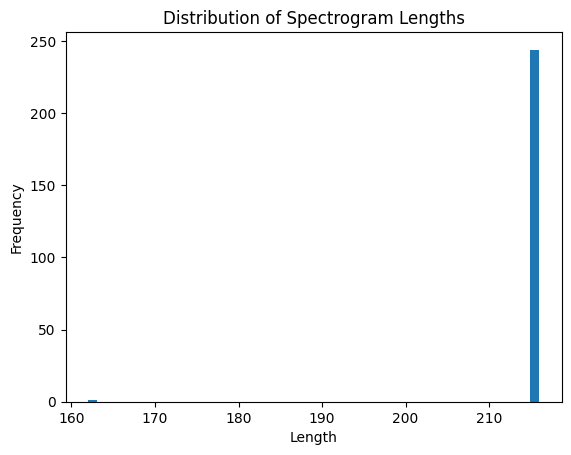

In [20]:
# Analyze the distribution of spectrogram lengths
spectrogram_lengths = [s.shape[1] for s in mel_spectrograms]

plt.hist(spectrogram_lengths, bins=50)
plt.title('Distribution of Spectrogram Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

# Set lower and upper limits for padding based on the distribution
lower_limit = 216
upper_limit = 216

# Filter spectrograms within the specified limits
filtered_data = [(s, l, p) for s, l, p in zip(mel_spectrograms, labels, patient_ids) if s.shape[1] >= lower_limit and s.shape[1] <= upper_limit]
filtered_spectrograms, filtered_labels, filtered_patient_ids = zip(*filtered_data)

# Manually pad spectrograms to the upper limit
max_length = upper_limit
padded_spectrograms = [np.pad(s, ((0, 0), (0, max_length - s.shape[1])), mode='constant') for s in filtered_spectrograms]

# Convert to numpy array
X_padded = np.array(padded_spectrograms)
y = np.array(filtered_labels)

X_padded.shape, y.shape

((244, 128, 216), (244,))

In [24]:
pd.Series(y).value_counts()

1    134
0    110
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_padded.reshape(-1, X_padded.shape[-1])).reshape(X_padded.shape)

In [ ]:
import pandas as pd

# Create a DataFrame to help with grouping by patient ID
data_df = pd.DataFrame({
    'spectrogram': list(X_normalized),
    'label': y,
    'patient_id': filtered_patient_ids
})

# Group data by patient_id
grouped = data_df.groupby('patient_id')

# Shuffle the groups
group_keys = list(grouped.groups.keys())
np.random.seed(42)
np.random.shuffle(group_keys)

# Split the groups into train and test sets to maintain a 7:3 ratio by the number of samples
train_data = []
test_data = []
train_size = 0
test_size = 0
total_size = len(data_df)

for key in group_keys:
    group = grouped.get_group(key)
    if train_size / total_size < 0.7:
        train_data.append(group)
        train_size += len(group)
    else:
        test_data.append(group)
        test_size += len(group)

train_data = pd.concat(train_data).reset_index(drop=True)
test_data = pd.concat(test_data).reset_index(drop=True)

# Extract the spectrograms and labels for training and testing
X_train = np.stack(train_data['spectrogram'].values)
y_train = train_data['label'].values
X_test = np.stack(test_data['spectrogram'].values)
y_test = test_data['label'].values

# Print the shapes of the datasets
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Labels Shape:", y_test.shape)

# Print the summary of who is included in X_train and how many data each one of them have
train_summary = train_data['patient_id'].value_counts()
print("Training Data Summary (patient_id : count):")
print(train_summary)

# Print the summary of who is included in X_test and how many data each one of them have
test_summary = test_data['patient_id'].value_counts()
print("Testing Data Summary (patient_id : count):")
print(test_summary)

Training Data Shape: (174, 128, 216)
Testing Data Shape: (70, 128, 216)
Training Labels Shape: (174,)
Testing Labels Shape: (70,)
Training Data Summary (patient_id : count):
patient_id
/content/drive/MyDrive/Italian Parkinson's Voice and speech/22 Elderly Healthy Control/MARIACRISTINA P             5
/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/6-10/Nicola S       5
/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/6-10/Ugo B          5
/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/6-10/Luigi B        5
/content/drive/MyDrive/Italian Parkinson's Voice and speech/22 Elderly Healthy Control/SUMMO L                     5
/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/11-16/Anna B        5
/content/drive/MyDrive/Italian Parkinson's Voice and speech/28 People with Parkinson's disease/1-5/Roberto R     

In [ ]:
def add_noise(data, noise_factor=0.1):
    noise = np.random.randn(*data.shape)
    augmented_data = data + noise_factor * noise
    augmented_data = np.clip(augmented_data, 0., 1.)
    return augmented_data

# Initialize lists to store augmented data and labels
augmented_data_list = [X_train]
augmented_labels_list = [y_train]

# Number of augmentations
num_augmentations = 4

import numpy as np
import scipy.signal
import random

def add_noise(data, noise_factor=0.1):
    noise = np.random.randn(*data.shape)
    augmented_data = data + noise_factor * noise
    augmented_data = np.clip(augmented_data, 0., 1.)
    return augmented_data

def add_reverberation(data, reverb_factor=0.5):
    reverb_kernel = np.ones(int(reverb_factor * 100)) / 100
    augmented_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            augmented_data[i, j, :] = scipy.signal.convolve(data[i, j, :], reverb_kernel, mode='full')[:data.shape[2]]
    augmented_data = np.clip(augmented_data, 0., 1.)
    return augmented_data

def add_clipping(data, clip_factor=0.5):
    threshold = clip_factor * np.max(data)
    augmented_data = np.clip(data, -threshold, threshold)
    return augmented_data

# Initialize lists to store augmented data and labels
augmented_data_list = [X_train]
augmented_labels_list = [y_train]

# Number of augmentations
num_augmentations = 1

# Augment data in a loop
for _ in range(num_augmentations):
    # Apply additive noise
    X_additive_noise = add_noise(X_train)
    augmented_data_list.append(X_additive_noise)
    augmented_labels_list.append(y_train)

    # Apply additive noise
    X_additive_noise_2 = add_noise(X_train)
    augmented_data_list.append(X_additive_noise_2)
    augmented_labels_list.append(y_train)

    # Apply reverberation
    X_reverb = add_reverberation(X_train)
    augmented_data_list.append(X_reverb)
    augmented_labels_list.append(y_train)

    # Apply clipping
    X_clipping = add_clipping(X_train)
    augmented_data_list.append(X_clipping)
    augmented_labels_list.append(y_train)

# Combine original and augmented data and labels
X_train_combined = np.concatenate(augmented_data_list, axis=0)
y_train_combined = np.concatenate(augmented_labels_list, axis=0)

# Verify the shapes
print("Original X_train shape:", X_train.shape)
print("Combined X_train shape:", X_train_combined.shape)
print("Original y_train shape:", y_train.shape)
print("Combined y_train shape:", y_train_combined.shape)


# Combine original and augmented data and labels
X_train_combined = np.concatenate(augmented_data_list, axis=0)
y_train_combined = np.concatenate(augmented_labels_list, axis=0)

Original X_train shape: (174, 128, 216)
Combined X_train shape: (870, 128, 216)
Original y_train shape: (174,)
Combined y_train shape: (870,)


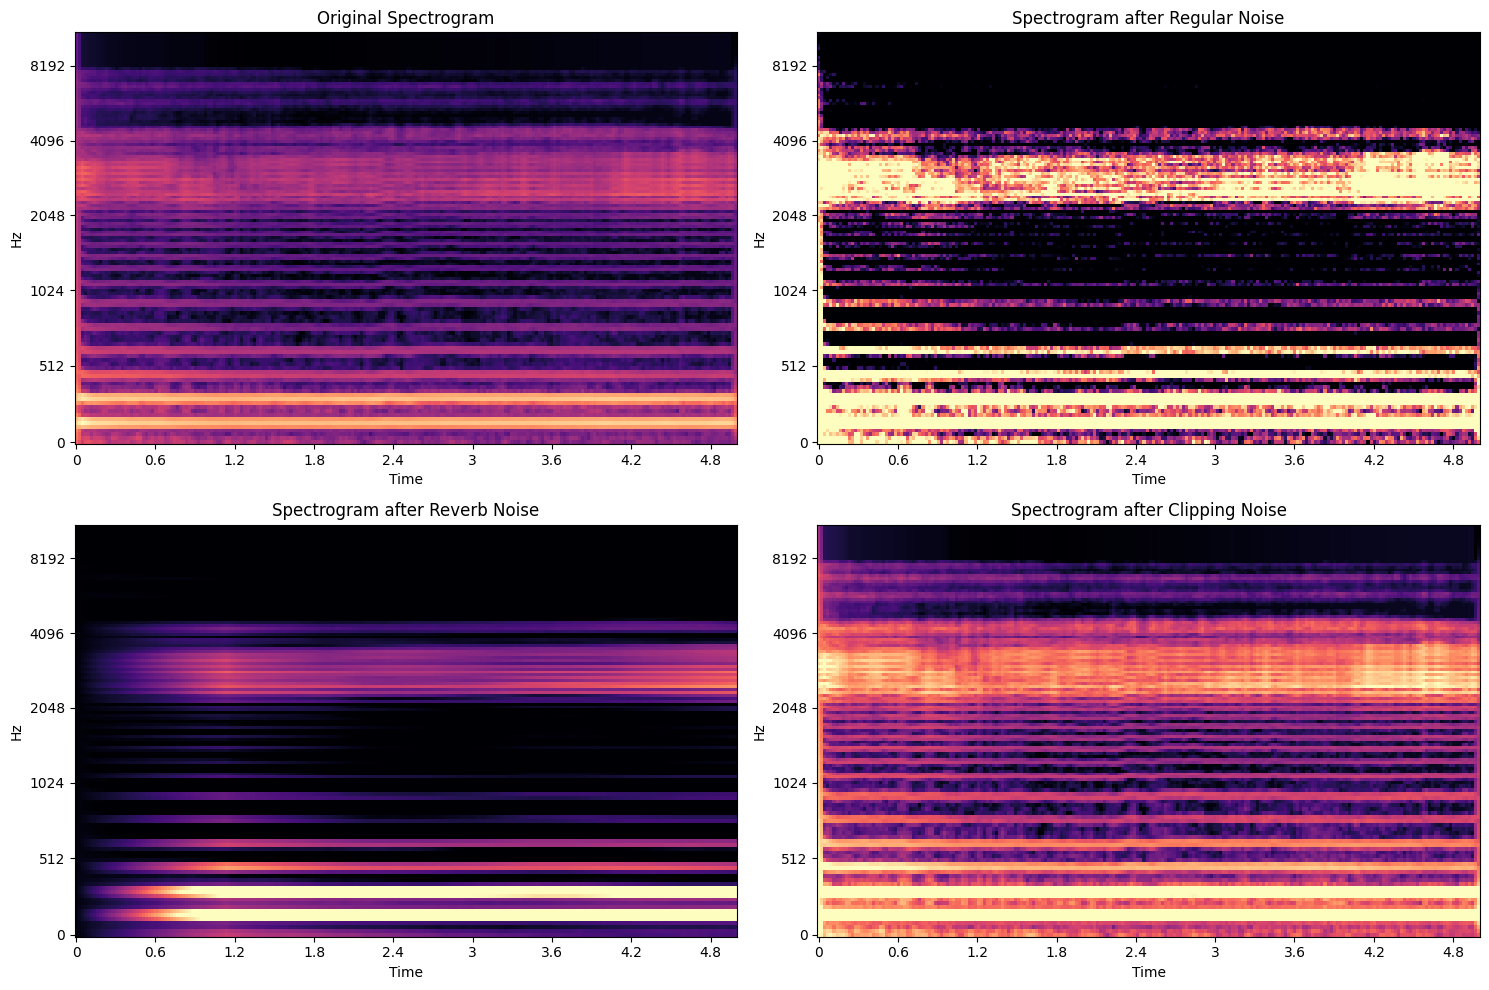

In [ ]:
# Select a single sample from X_train
index = 3  # Change this to visualize a different sample
sr = 22050
hop_length = 512
original_sample = X_train[index]

# Apply augmentations
sample_noise = add_noise(np.expand_dims(original_sample, axis=0))[0]
sample_reverb = add_reverberation(np.expand_dims(original_sample, axis=0))[0]
sample_clipping = add_clipping(np.expand_dims(original_sample, axis=0))[0]

# Plot the spectrograms
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original spectrogram
axes[0, 0].set_title("Original Spectrogram")
librosa.display.specshow(original_sample, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma', ax=axes[0, 0])

# Spectrogram after regular noise
axes[0, 1].set_title("Spectrogram after Regular Noise")
librosa.display.specshow(sample_noise, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma', ax=axes[0, 1])

# Spectrogram after reverb noise
axes[1, 0].set_title("Spectrogram after Reverb Noise")
librosa.display.specshow(sample_reverb, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma', ax=axes[1, 0])

# Spectrogram after clipping noise
axes[1, 1].set_title("Spectrogram after Clipping Noise")
librosa.display.specshow(sample_clipping, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma', ax=axes[1, 1])

plt.tight_layout()

plt.savefig("/content/drive/MyDrive/CNN After Noise.png")
plt.show()

In [ ]:
X_train_combined.shape, y_train_combined.shape

((870, 128, 216), (870,))

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, max_length, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 214, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 126, 214, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 107, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 105, 64)       18496     
                                                                 
 batch_normalization_4 (Bat  (None, 61, 105, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
# Train the model
history = model.fit(X_train_combined, y_train_combined, epochs=20)
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
28/28 [==============================] - 3s 24ms/step - loss: 3.2403 - accuracy: 0.7345
Epoch 2/20
28/28 [==============================] - 1s 23ms/step - loss: 0.5141 - accuracy: 0.9161
Epoch 3/20
28/28 [==============================] - 1s 23ms/step - loss: 0.2398 - accuracy: 0.9391
Epoch 4/20
28/28 [==============================] - 1s 24ms/step - loss: 0.1123 - accuracy: 0.9747
Epoch 5/20
28/28 [==============================] - 1s 27ms/step - loss: 0.0518 - accuracy: 0.9782
Epoch 6/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0287 - accuracy: 0.9897
Epoch 7/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0527 - accuracy: 0.9862
Epoch 8/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0368 - accuracy: 0.9920
Epoch 9/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0160 - accuracy: 0.9966
Epoch 10/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0088 - accuracy: 0.9977
Epoch 11/

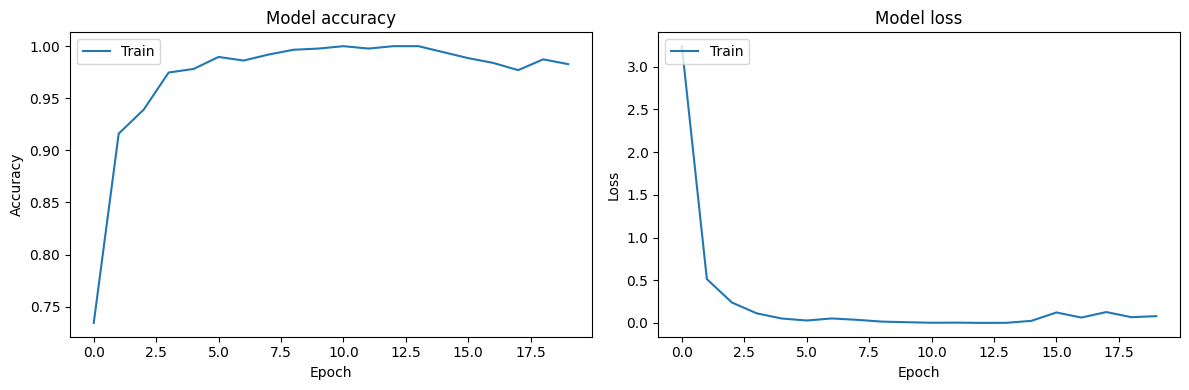

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()

plt.savefig("/content/drive/MyDrive/CNN Training.png")
plt.show()

3/3 [==============================] - 0s 6ms/step
Test Accuracy: 92.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.98      0.91      0.94        45

    accuracy                           0.93        70
   macro avg       0.92      0.94      0.92        70
weighted avg       0.93      0.93      0.93        70



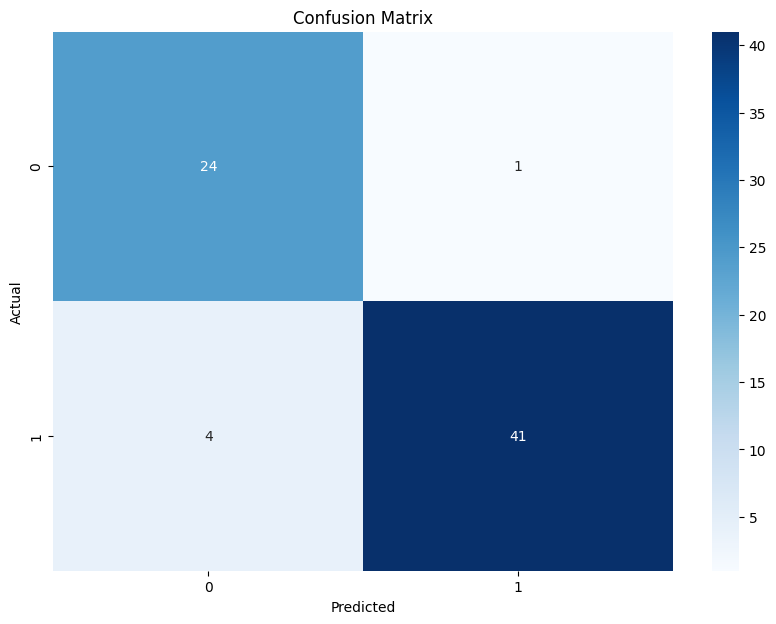

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig("/content/drive/MyDrive/CNN Result.png")
plt.show()

3/3 [==============================] - 0s 7ms/step
AUC: 0.95


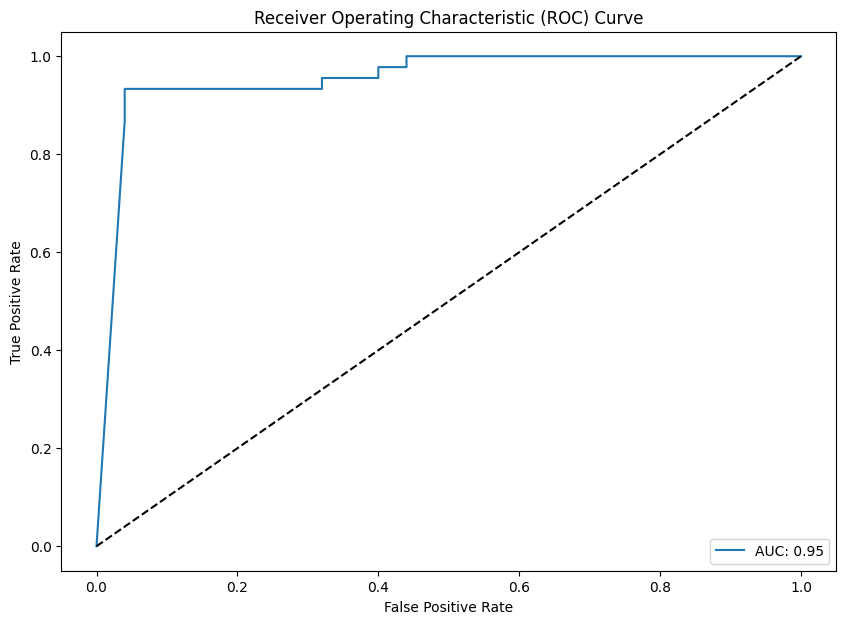

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model.predict(X_test)

auc = roc_auc_score(y_test, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig("/content/drive/MyDrive/CNN ROC Curve.png")
plt.show()

In [ ]:
# Save the model
model.save(model_save_path)

In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model(model_save_path)
print(f"Model loaded from {model_save_path}")

Model loaded from /content/drive/MyDrive/Italian Parkinson's Voice and speech_CNN.keras


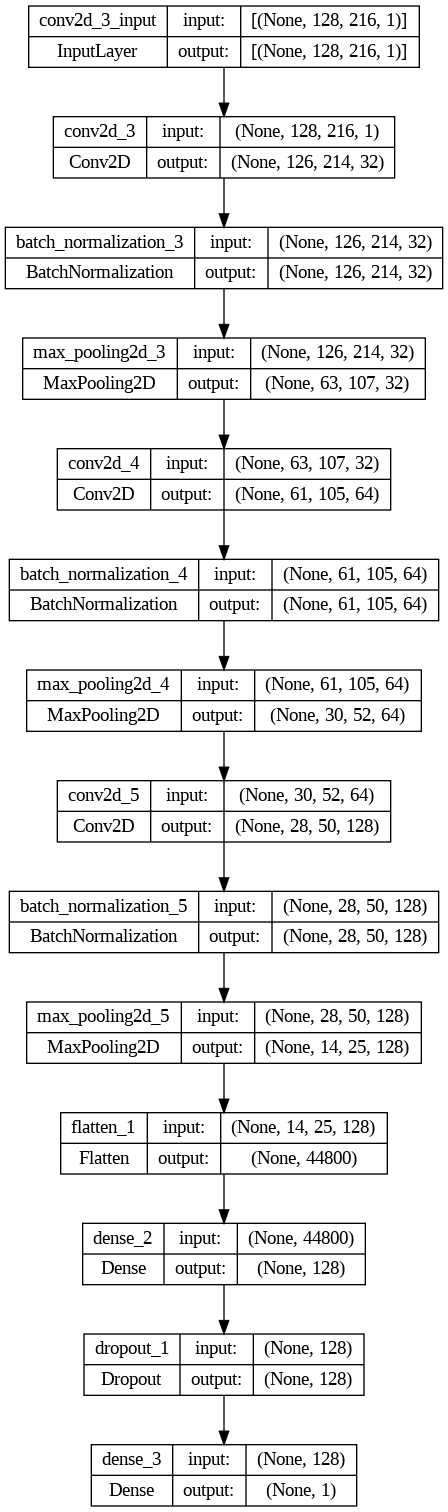

In [ ]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(model, to_file='/content/drive/MyDrive/CNN model architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architecture
from IPython.display import Image
Image('/content/drive/MyDrive/CNN model architecture.png')

<ipython-input-67-d25a9a4e83e9>:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)


Plot saved to /content/drive/MyDrive/CNN GRAD-CAM.png


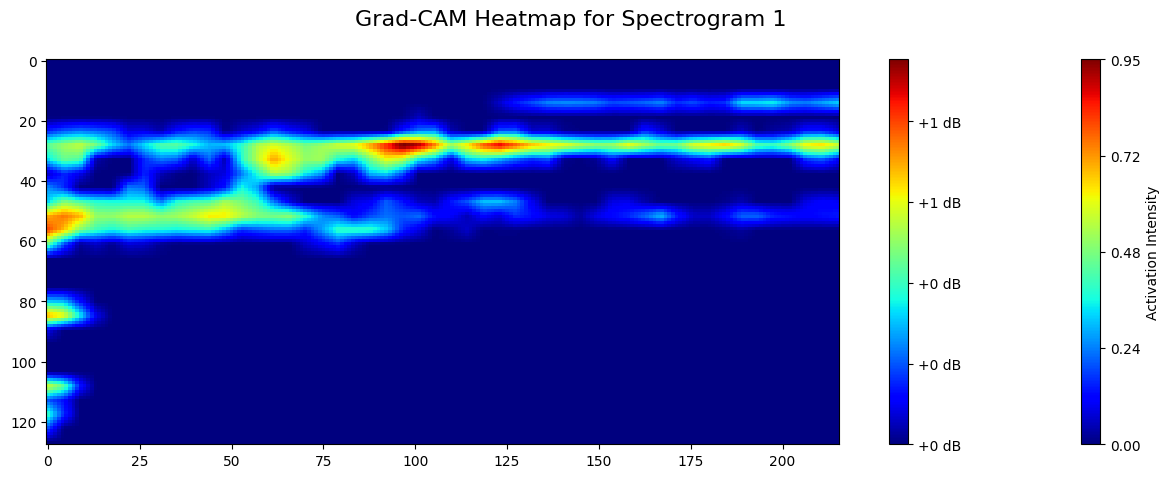

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom
import matplotlib.colors as mcolors

def compute_gradcam(model, img_array, layer_index):
    grad_model = tf.keras.models.Model(inputs=[model.inputs], outputs=[model.layers[layer_index].output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap

#def resize_heatmap(heatmap, target_shape):
#    heatmap_resized = np.zeros(target_shape)
#    for i in range(heatmap.shape[0]):
#        heatmap_resized[i, :] = np.interp(np.arange(target_shape[1]),
#                                          np.linspace(0, target_shape[1], num=heatmap.shape[1]),
#                                          heatmap[i, :])
#    return heatmap_resized

def resize_heatmap(heatmap, target_shape):
    zoom_factors = (target_shape[0] / heatmap.shape[0], target_shape[1] / heatmap.shape[1])
    heatmap_resized = zoom(heatmap, zoom_factors, order=1)
    return heatmap_resized

def plot_gradcam_over_spectrogram(heatmap, spectrogram, sr, hop_length, index, save_path=None):
    plt.figure(figsize=(14, 5))

    # Display the spectrogram with a more colorful colormap
    # librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma')

    try:
        # Resize the heatmap to match the spectrogram dimensions
        heatmap_resized = resize_heatmap(heatmap, spectrogram.shape)
        plt.imshow(heatmap_resized, cmap='jet', alpha=1, aspect='auto')

        # Create custom colormap and normalization
        norm = mcolors.Normalize(vmin=np.min(heatmap_resized), vmax=np.max(heatmap_resized))
        sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
        sm.set_array([])

        # Add colorbar
        cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)
        cbar.set_label('Activation Intensity')  # Customize label as needed

        # Set ticks and labels for the colorbar
        tick_labels = np.linspace(np.min(heatmap_resized), np.max(heatmap_resized), num=5)
        cbar.set_ticks(tick_labels)
        cbar.set_ticklabels([f'{t:.2f}' for t in tick_labels])

    except ValueError as e:
        print(f"ValueError: {e}. Skipping this plot.")

    plt.colorbar(format='%+1.0f dB')
    plt.suptitle(f'Grad-CAM Heatmap for Spectrogram {index}', fontsize=16)

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    plt.show()


# Find the index of the last convolutional layer
last_conv_layer_index = None
for i, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_index = i

# Ensure the index was found
if last_conv_layer_index is None:
    raise ValueError("No convolutional layer found in the model.")

# Assuming sr and hop_length are known or can be set here
sr = 22050  # Set to the correct sampling rate if known
hop_length = 512  # Set to the correct hop length if known

# Select a sample from X_train
index =  1 # Change this to visualize a different sample
sample = X_train[index].reshape(1, 128, max_length, 1)

# Compute Grad-CAM
heatmap = compute_gradcam(model, sample, last_conv_layer_index)

# Plot the Grad-CAM heatmap over the spectrogram
plot_gradcam_over_spectrogram(heatmap, X_train[index], sr, hop_length, index, save_path = '/content/drive/MyDrive/CNN GRAD-CAM.png')

In [ ]:
import numpy as np
import tensorflow as tf
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Define the function to extract Mel-spectrogram from an audio file
def extract_mel_spectrogram(audio_path, n_mels=128, n_fft=2048, hop_length=512, duration=5):
    try:
        y, sr = librosa.load(audio_path, duration=duration)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None


# Load and preprocess the new .wav file
audio_path = "/content/drive/MyDrive/Fun Data/Parkinson u.wav"
mel_spectrogram = extract_mel_spectrogram(audio_path)

if mel_spectrogram is not None:
    # Normalize the Mel-spectrogram
    scaler = StandardScaler()
    mel_spectrogram_normalized = scaler.fit_transform(mel_spectrogram.T).T  # Transpose to normalize each frequency band independently

    # Ensure the Mel-spectrogram has the expected input shape for the model
    if mel_spectrogram_normalized.shape[0] == 128:  # Ensure it has 128 Mel bands
        mel_spectrogram_normalized = mel_spectrogram_normalized[np.newaxis, :, :, np.newaxis]  # Add batch and channel dimensions

        # Make predictions
        prediction = model.predict(mel_spectrogram_normalized)
        print(f"Prediction: {prediction}")
    else:
        print(f"Unexpected Mel-spectrogram shape: {mel_spectrogram_normalized.shape}")
else:
    print("Failed to extract Mel-spectrogram from the audio file.")

1/1 [==============================] - 0s 47ms/step
Prediction: [[9.705894e-08]]
